# Hackathon MKB 2021



Денис Иванов


## 1. Импорт библиотек и загрузка данных 

In [1]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split , StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import catboost as cb

In [3]:
!wget https://github.com/dsbattle/hackathon-mkb/raw/master/train_dataset_hackathon_mkb.csv
!wget https://github.com/dsbattle/hackathon-mkb/raw/master/test_dataset_hackathon_mkb.csv

--2022-01-09 10:44:00--  https://github.com/dsbattle/hackathon-mkb/raw/master/train_dataset_hackathon_mkb.csv
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsbattle/hackathon-mkb/master/train_dataset_hackathon_mkb.csv [following]
--2022-01-09 10:44:01--  https://raw.githubusercontent.com/dsbattle/hackathon-mkb/master/train_dataset_hackathon_mkb.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9253323 (8.8M) [text/plain]
Saving to: ‘train_dataset_hackathon_mkb.csv’

train_dataset_hacka 100%[===================>]   8.82M  --.-KB/s    in 0.1s    

2022-01-09 10:44:02 (81.1 MB/s) - ‘train_datas

In [4]:
train = pd.read_csv('train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
test  = pd.read_csv('test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
train.head(1)

id_contract  id_client           SIGN_DATE  ...  AGE  SEX_NAME  CITIZENSHIP_NAME
0            1       1847  01JAN2018:00:00:00  ...  NaN       NaN               NaN

[1 rows x 124 columns]

## 2. Вспомогательные функции

In [5]:
def OHE(col_name, df = train):
    df = df.astype('category')
    ohe_enc  = OneHotEncoder()
    type_values = ohe_enc.fit_transform(df[[col_name]]).toarray()
    type_columns= [col_name + '_' + str(i) for i in ohe_enc.categories_[0]]
    type_data   = pd.DataFrame(type_values, columns = type_columns)
    return type_data

In [6]:
def corr_matrix(data, name):
    data_corr = data.corr().round(2)
    sns.set(rc={'figure.figsize':(len(data.columns),len(data.columns))})
    ax = sns.heatmap(data_corr,  
                annot = True, 
                fmt='.1g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True, cbar=False)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)

In [7]:
def feature_report(data, targets, feature_col):
    output_y = targets
    input_x  = data.loc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.2, 
                                                        random_state = 1000)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    scor       = 100*model.score(x_test, y_test)
    print(classification_report(y_test, model_pred))
    print('Точность модели составила (%)', scor)
    headers = list(input_x.columns.values)
    feature_imp = pd.Series(model.feature_importances_,
                            index=headers).sort_values(ascending=False)
    if len(headers) >2:
        f, ax = plt.subplots(figsize=(10, len(headers)*0.5))
        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Уровень значимости параметров')
        plt.ylabel('Параметры')
        plt.title('Рэнкинг значимости параметров')
        plt.show()
    return feature_imp, scor

## 3. Классификация / конструирование признаков обучения

### 3.0.  Формирование однородных портфелей (ПОС)

Среди клиентов имеем 3 группы, которые различаются: 
- по составу информации в датасете,
- форма налогового учета и отчетности,
- характеристики потребительского поведения / спецификам кредитного обслуживания,

это есть: 
- Юридические лица на полной системе налогообложения 
(есть баланс и опиу,  характерны все признаки кроме пола и возраста физ лица)
- Юр. лица на упрощенной системе налогообложения (то же но нет фин отчетности)
- Индивидуальные предприниматели (нет фин отчетности не участвуют в тендерах по госзакупкам, нет ряда специфических  признаков юр лиц (см ниже)


In [8]:
def form_cols(df_):
    df_.loc[(df_.IP_flag==0)&(df_.F1600 > 0) &(df_.F2110 > 0),      
                                      'client_OPF'] = 'Comp_OSN'
    df_.loc[(df_.IP_flag==1),         'client_OPF'] = 'IP'
    df_.loc[(df_.client_OPF.isna()),  'client_OPF'] = 'Comp_USN'
    return df_

def form_pos(df):    
    df    = form_cols(df)
    OSN_i = df[df.client_OPF == 'Comp_OSN'].index.tolist()
    USN_i = df[df.client_OPF == 'Comp_USN'].index.tolist()
    IP_i  = df[df.client_OPF == 'IP'].index.tolist()

    df.loc[(df.F1600>0)&(df.F2110.isna())&(df.F1300==10000), 'usn_fich'] = 1
    df['usn_fich'] = df['usn_fich'].fillna(0)
    return df['client_OPF'], df['usn_fich'].reset_index(), OSN_i, USN_i, IP_i

In [9]:
train_1 = form_cols(train)

### 3.1. Целевая переменная (что не так)

In [10]:
control_df = train_1.groupby(['id_client', 'client_OPF']
                        ).TARGET.agg([np.sum, np.size]).reset_index()
control_df.columns = ['id_client', 'client_OPF',	
                      'count_of_defolts', 'count_of_garantees']

In [11]:
pd.cut(control_df.count_of_defolts,[-1, 1, 10, 100, 999]).value_counts()

(-1, 1]       8508
(1, 10]        442
(10, 100]       97
(100, 999]      11
Name: count_of_defolts, dtype: int64

In [12]:
train.TARGET.mean()

0.4130009501984238

В рамках "обычных" практик кредитной работы сложно представить бизнес модель, в составе которой:
-  41% наблюдений относятся к дефолтным,  
- 1 Клиент в течение периода наблюдения (1 года) допустил более 100 дефолтов, и это событие не повлекло бы за собой прекращение обслуживания / инициирование процедур взыскания.  

Предполагаю, что: 
- определение дефолта "по модели" и "по жизни" может различаться

Догадываюсь, что раскрытие банковской гарантии, указанное в модели как дефолт, может являться обычной практикой, а для обеспечения устойчивости работы модели дефолтом возможно признать факт  допущения просрочки по регрессному требованию сроком свыше 30 (90) дней

In [13]:
print('Доля плохих наблюдений в среднем по датасету = ', train.TARGET.mean()*100)
print('в том числе по ЮЛ с ОСН',  train[train.client_OPF=='Comp_OSN'
                                                            ].TARGET.mean()*100)
print('в том числе по ЮЛ с УСН',  train[train.client_OPF=='Comp_USN'
                                                            ].TARGET.mean()*100)
print('в том числе по ИП      ',  train[train.client_OPF=='IP'
                                                            ].TARGET.mean()*100)

Доля плохих наблюдений в среднем по датасету =  41.30009501984238
в том числе по ЮЛ с ОСН 37.18632508524963
в том числе по ЮЛ с УСН 65.13202437373053
в том числе по ИП       34.62857142857143


In [14]:
control_df['bad_rate'] = control_df.count_of_defolts/control_df.count_of_garantees
control_df.groupby(['client_OPF']).bad_rate.mean()

client_OPF
Comp_OSN    0.187364
Comp_USN    0.344773
IP          0.187664
Name: bad_rate, dtype: float64

ЮЛ с упрощенной формой налогообложения в 2 раза чаще / быстрее оказываются в дефолте - меньше всего достоверной  информации на входе - закономерно

In [15]:
form_pos(train)[1].join(train.iloc[:,4]).groupby(['usn_fich']).TARGET.mean()

usn_fich
0.0    0.405652
1.0    0.892593
Name: TARGET, dtype: float64

Очевидные точки концентрации кредитного риска / 89,25% плохих наблюдений сосредоточено на клиентах, удовлетворяющих следующим 2 признакам:

- собственный капитал == 10 000 руб;
- выручка по ОПИУ = 0.

Признаки соответствуют вновь открытым предприятиям без капитала и опыта работы.

### 3.2. Универсальные признаки

In [16]:
def code_cols(d):
    df = d.copy(deep=True)

    #  признак по географии / косвенная завязка на территориальное подразделение Банка
    df['OKATO_FED'] = df['OKATO_FED'].fillna(0).round(0).astype(str)
    df['OKVED_CODE']= df['OKVED_CODE'].fillna(0).astype(str)
    
    # основной вид деятельности (ОКВЭД / 1 грейд классификации)
    df['OKVED_CODE'] = df['OKVED_CODE'].astype(str)
    df['OKVED_CODE'] = [i[:2] for i in df['OKVED_CODE']]
    top_OKVED        = df['OKVED_CODE'].value_counts()[:20].index
    df['OKVED_CODE_short'] = [str(i) if i in top_OKVED else '0'
                             for i in df['OKVED_CODE']]
                             
    # юридический возраст / количество месяцев с даты гос регистрации до даты контракта
    df['DATEFIRSTREG'] = df['DATEFIRSTREG'].astype(str)
    df['DATEFIRSTREG'] = [(pd.to_datetime(df.SIGN_DATE[i][:9])-
                          pd.to_datetime(df.DATEFIRSTREG[i][:9])).days/30.5
                          if df['DATEFIRSTREG'][i] != 'nan' else 0 
                          for i in df.index]
    df.loc[df.DATEFIRSTREG<0,   'DATEFIRSTREG']   =0
    df['DATEFIRSTREG_group'] = pd.cut(df['DATEFIRSTREG'],[-1,0.01,12,36,60,120,999], list(range(8)))
    df['DATEFIRSTREG_age']   = df['DATEFIRSTREG']

    # количество заключенных контрактов / гарантий - опыт работы с банком
    df['num_contract'] = 0
    for i in range (len(df)):
        df.iloc[i,-1] = (df.id_client[:i]==df.iloc[i,1]).sum()   
    df['num_contract_short'] = pd.qcut(df.num_contract,10,duplicates='drop')

    code_fich_group = pd.concat([OHE('DATEFIRSTREG_group', df).iloc[:,:-1],
                                 OHE('OKATO_FED' , df).iloc[:,:-1],
                                 OHE('OKVED_CODE_short',df).iloc[:,:-1],
                                 OHE('num_contract_short',df).iloc[:,:-1]], axis = 1)
    
    return code_fich_group

### 3.3.  Участие в тендарах по госзакупкам и подобных (кроме ИП)


Не нашел различий по сущности закупкок по  ФЗ 95 и 233, значимых для кредитного анализа - взял сумму

In [17]:
def tender_cols(d):
    df = d.copy(deep=True)
    #  % допуска к торгам за год
    #df.loc[(df.ADMITTEDNUMBER_233_YEAR + df.ADMITTEDNUMBER_95_YEAR + 
    #           df.NOTADMITTEDNUMBER_233_YEAR + df.NOTADMITTEDNUMBER_95_YEAR)>0, 
    #            't_dopusk_year'] = (df.ADMITTEDNUMBER_233_YEAR + 
    #                                df.ADMITTEDNUMBER_95_YEAR
    #                             ) /(df.ADMITTEDNUMBER_233_YEAR + 
    #                                df.ADMITTEDNUMBER_95_YEAR + 
    #                                df.NOTADMITTEDNUMBER_233_YEAR + 
    #                                df.NOTADMITTEDNUMBER_95_YEAR)

    #  % выигранных торгов за год
    df.loc[(df.ADMITTEDNUMBER_233_YEAR + df.ADMITTEDNUMBER_95_YEAR)>0,
                't_win_year'] = (df.WINNERNUMBER_233_YEAR + 
                                 df.WINNERNUMBER_95_YEAR
                            ) / (df.ADMITTEDNUMBER_233_YEAR + 
                                 df.ADMITTEDNUMBER_95_YEAR)

    # % подписано контрактов к выигранныым тендорам
    #df.loc[(df.WINNERNUMBER_233_YEAR+df.WINNERNUMBER_95_YEAR)>0, 
    #            't_sig_win_year']  = (df.SIGNEDNUMBER_233_YEAR + 
    #                                  df.SIGNEDNUMBER_95_YEAR
    #                             ) / (df.WINNERNUMBER_233_YEAR + 
    #                                  df.WINNERNUMBER_95_YEAR)

    # количество контрактов за год
    #df['t_kol_contracts'] = df.SIGNEDNUMBER_233_YEAR + df.SIGNEDNUMBER_95_YEAR

    # доля тендерных контрактов в выручке за год                          
    df.loc[df.F2110>0, 't_sum_salar_year']=(df.SUM_233_YEAR + df.SUM_95_YEAR) / df.F2110

    # доля контрактов последнего года в истории
    df.loc[(df.SUM_233_EVER + df.SUM_95_EVER)>0, 
                    't_sum_year_ever']= (df.SUM_233_YEAR + df.SUM_95_YEAR) / (
                                        df.SUM_233_EVER + df.SUM_95_EVER)
    
    tend_fich = df.iloc[:,-3:].fillna(0)
    #tend_fich.loc[tend_fich.t_sig_win_year>1.1,  't_sig_win_year']   = 1.1
    tend_fich.loc[tend_fich.t_sum_salar_year>3,  't_sum_salar_year']  = 3
    #tend_fich.loc[tend_fich.t_kol_contracts>2000,'t_kol_contracts']   = 2000

    return tend_fich

### 3.4. Участие в судебных процессах / универсальный признак

In [18]:
def sud_cols(d):
    df = d.copy(deep=True)

    # Средняя сумма иска предьявленного
    df.loc[df.PLAINTIFF_CASESNUMBER_YEAR >0, 
            's_avg_isk_year']   = df.PLAINTIFF_SUM_YEAR / df.PLAINTIFF_CASESNUMBER_YEAR

    # средняя сумма иска полученного
    df.loc[df.DEFENDANT_CASESNUMBER_YEAR >0, 
            's_avg_otv_year']   = df.DEFENDANT_SUM_YEAR / df.DEFENDANT_CASESNUMBER_YEAR
    
    # значимость сумм поданных и предьявленных исков / отношение к готовой выручке
    df.loc[df.F2110 >0, 
            's_isk_sales_year'] = df.PLAINTIFF_SUM_YEAR / df.F2110
    
    df.loc[df.F2110 >0, 
            's_otv_sales_year'] = df.DEFENDANT_SUM_YEAR / df.F2110
        
    # существенность исков за последний год  (доля по сумме последнего года в общей сумме исков)
    df.loc[(df.DEFENDANT_SUM_YEAR >0)&
              (df.DEFENDANT_SUM_EVER >df.DEFENDANT_SUM_YEAR)&
              (df.DEFENDANT_SUM_EVER / df.DEFENDANT_SUM_YEAR <999), 
             's_otv_year_eve']   = df.DEFENDANT_SUM_EVER / df.DEFENDANT_SUM_YEAR  
    df['s_otv_year_eve'].replace(np.inf,99,inplace=True)

    sud_fich = df.iloc[:,-5:].fillna(0)

    return sud_fich

### 3.5. Признаки юридических лиц специфические

In [19]:
def ul_cols(d):
    df = d.copy(deep=True)

    # количество наемных работников / здесь и далее укрупняем группы / чтобы обеспечить наглядную линейную зависимость 
    df.loc[df.WORKERSRANGE=='0 .. 5',  'WORKERSRANGE_1'] = 1
    df.loc[df.WORKERSRANGE=='6 .. 10', 'WORKERSRANGE_1'] = 6
    df.loc[df.WORKERSRANGE=='11 .. 15','WORKERSRANGE_1'] = 11
    df.loc[df.WORKERSRANGE=='16 .. 50','WORKERSRANGE_1'] = 11
    df.loc[df.WORKERSRANGE.isna(),     'WORKERSRANGE_1'] = 0
    df.loc[df.WORKERSRANGE_1.isna(),   'WORKERSRANGE_1'] = 50

    df.loc[df.COUNTCOOWNEREGRUL>3,  'COUNTCOOWNEREGRUL_1'] = 4
    df.loc[df.COUNTCOOWNEREGRUL<=3, 'COUNTCOOWNEREGRUL_1'] = df.COUNTCOOWNEREGRUL

    df.loc[df.COUNTBRANCHEGRUL>1, 'COUNTBRANCHEGRUL_1'] = 2
    df.loc[df.COUNTBRANCHEGRUL<=1,'COUNTBRANCHEGRUL_1'] = df.COUNTBRANCHEGRUL
    
    df.loc[df.TELEPHONECOUNT>2, 'TELEPHONECOUNT_1'] = 3
    df.loc[df.TELEPHONECOUNT<=2,'TELEPHONECOUNT_1'] = df.TELEPHONECOUNT

    df.loc[df.MANAGERINNCOUNT>2,  'MANAGERINNCOUNT_group'] = 3
    df.loc[df.MANAGERINNCOUNT==2, 'MANAGERINNCOUNT_group'] = 1
    df = df.fillna(0)

    ul_fich_group = pd.concat([ OHE('WORKERSRANGE_1', df).iloc[:,:-1],
                                OHE('COUNTCOOWNEREGRUL_1', df).iloc[:,[1,2,3]],
                                OHE('COUNTBRANCHEGRUL_1', df).iloc[:,1],
                                OHE('TELEPHONECOUNT_1', df).iloc[:,[1,2]],
                                OHE('MANAGERINNCOUNT_group', df).iloc[:,1]], 
                                axis = 1)

    return ul_fich_group

### 3.6. Оценка финансового состояния (для ЮЛ на общей системе налогобложения)

In [20]:
def fin_cols(df):
    df = df.fillna(0)

    #  Достаточность капитала (на покрытие оборотных активов)
    df['F_VOA']          = df.F1100 + df.F1240
    df.loc[(df.F_VOA >= 0)&(df.F1300 > 0), 
        'F_Capital/VOA']    = df.F1300 / df.F_VOA
    df.loc[df['F_Capital/VOA'] > 1, 'F_Capital/VOA'] = 1
    df.loc[((df.F1200-df.F1240) > 0)&
          ((df.F1300-df.F_VOA) > 0)&
          (df.F_VOA >= 0)&
          (df.F1300 >  0), 
        'F_(Capital-VOA)/OA']   = (df.F1300-df.F_VOA)/(df.F1200-df.F1240)
    df['F_Obesp_sos']           = df['F_Capital/VOA'] + df['F_(Capital-VOA)/OA']
    df.loc[df['F_Obesp_sos'] > 2, 'F_Obesp_sos'] = 2


    # Оборачиваемость оборотных активов
    df.loc[df.F2110 > 0, 
        'F_OA/Sales']        = (df.F1200-df.F1240) / df.F2110
    df.loc[df['F_OA/Sales'] >= 3, 'F_OA/Sales'] = 3 # выручка за год  - очевидный выброс
    
    # Годовая выручка к капиталу 
    df.loc[df.F1300 > 0, 
         'F_Sales/Capital']  = df.F2110 / df.F1300

    # Кредиторы к выручке
    df.loc[(df.F2110 > 0)&(df.F1400 > 0), 
        'F_LT_cred/Sales']   = df.F1400 / df.F2110
    df.loc[(df.F2110 > 0)&(df.F1510 > 0), 
        'F_ST_cred/Sales']   = df.F1510 / df.F2110        
    df.loc[(df.F2110 > 0)&(df.F1500 > 0), 
        'F_Creditors/Sales'] = (df.F1500 - df.F1510) / df.F2110

    # Банковские кредиты к Прибыли от продаж (в первом приближении  Долг/Ebitda)    
    df.loc[(df.F2200 > 0)&(train.F1410 > 0), 
        'F_BT_cred/SalesProf']= (df.F1410 + df.F1510) / df.F2200

    #Рентабельность выручки
    df.loc[(df.F2110) > 0&(df.F2300 > 0), 
        'F_Profit/Sales']     = df.F2300 / df.F2110

    # Динамика по ключевым статьям
    df.loc[(df.F1410_LAG1 > 0)&(df.F1410 > 0), 
        'F_delt_LT_cred']     = df.F1410 / df.F1410_LAG1
    df.loc[(df.F1510_LAG1 > 0)&(df.F1510 > 0), 
        'F_delt_ST_cred']     = df.F1510 / df.F1510_LAG1
    df.loc[(df.F2110_LAG1 > 0)&(df.F2110 > 0), 
        'F_delt_Sales']       = df.F2110 / df.F2110_LAG1
    df.loc[(df.F2300_LAG1 > 0)&(df.F2300 > 0), 
        'F_delt_prof']        = df.F2300 / df.F2300_LAG1
    df.loc[(df.F2200_LAG1 > 0)&(df.F2200 > 0), 
        'F_delt_sales_prof']  = df.F2200 / df.F2200_LAG1

    fin_fich = df.iloc[:,-13:].fillna(0)
    for col in fin_fich.columns[-11:]:
        if fin_fich[col].max() > 1000:
            fin_fich.loc[fin_fich[col] >1000, col] = 1000
            
    return fin_fich

### 3.7.  Показатели ИП / физ лиц - пол и возраст

In [21]:
def fl_cols(d):
    df = d.copy(deep=True)#.fillna(0)
    
    df.loc[:,'AGE_group'] = pd.qcut(df['AGE'], 5, duplicates='drop')

    fl_fich_group_1  = OHE('AGE_group', df).iloc[:,:-1]
    fl_fich_group_2  = OHE('SEX_NAME',  df).iloc[:,:-2]

    return fl_fich_group_1, fl_fich_group_2

 ### 3.8. Сборка датасетов под задачу

In [22]:
def make_dataset():
 
    OPf_c_train, USN_f_train, OSN_i_train, USN_i_train, IP_i_train=form_pos(train)
    OPf_c_test,  USN_f_test,  OSN_i_test,  USN_i_test,  IP_i_test =form_pos(test)

    code_train,  code_test = code_cols(train),   code_cols(test)
    tend_train,  tend_test = tender_cols(train), tender_cols(test)
    sud_train,   sud_test  = sud_cols(train), sud_cols(test)
    fin_train,   fin_test  = fin_cols(train), fin_cols(test)
    ul_train,    ul_test   = ul_cols(train), ul_cols(test)
    f_1_train, f_2_train   = fl_cols(train)
    f_1_test, f_2_test     = fl_cols(test)

    train_list = [USN_f_train]+[code_train, tend_train, sud_train, fin_train, 
                                ul_train, f_1_train, f_2_train]
    test_list  = [USN_f_test]+[code_test, tend_test, sud_test, fin_test, 
                                ul_test, f_1_test, f_2_test]
    
    df_1 = pd.concat(train_list, axis =1).iloc[:,1:]
    df_2 = pd.concat(test_list,  axis =1).iloc[:,1:] 

    train_i= [OSN_i_train, USN_i_train, IP_i_train]
    test_i = [OSN_i_test, USN_i_test, IP_i_test]

    return train_i, test_i, df_1, df_2

In [23]:
train_index, test_index, df_train, df_test = make_dataset()

In [24]:
df_cols = [i for i in df_test.columns if i in df_train.columns]

df_train= df_train.loc[:,df_cols]
df_test = df_test.loc[:, df_cols]

In [25]:
OSN_stop = ['us', 'AG', 'SE']
USN_stop = ['F_', 'AG', 'SE']
IP_stop  = [ 'F_', 't_',  'WO',  'CO', 'TE', 'us']

local_stop_cols = ['s_isk_sales_year', 't_sum_salar_year']

X_OSN_columns = [i for i in df_test.columns  if i[:2] not in OSN_stop]
X_USN_columns = [i for i in df_test.columns  if i[:2] not in USN_stop
                                             if i not in local_stop_cols]
X_IP_columns  = [i for i in df_test.columns  if i[:2] not in IP_stop
                                             if i not in local_stop_cols]

X_train_OSN = df_train.loc[train_index[0], X_OSN_columns]
y_train_OSN = train.loc[train_index[0], 'TARGET'].values.reshape(-1,1)
X_test_OSN  = df_test.loc[test_index[0], X_OSN_columns]

X_train_USN = df_train.loc[train_index[1], X_USN_columns]
y_train_USN = train.loc[train_index[1], 'TARGET'].values.reshape(-1,1)
X_test_USN  = df_test.loc[test_index[1], X_USN_columns]

X_train_IP = df_train.loc[train_index[2], X_IP_columns]
y_train_IP = train.loc[train_index[2], 'TARGET'].values.reshape(-1,1)
X_test_IP  = df_test.loc[test_index[2], X_IP_columns]

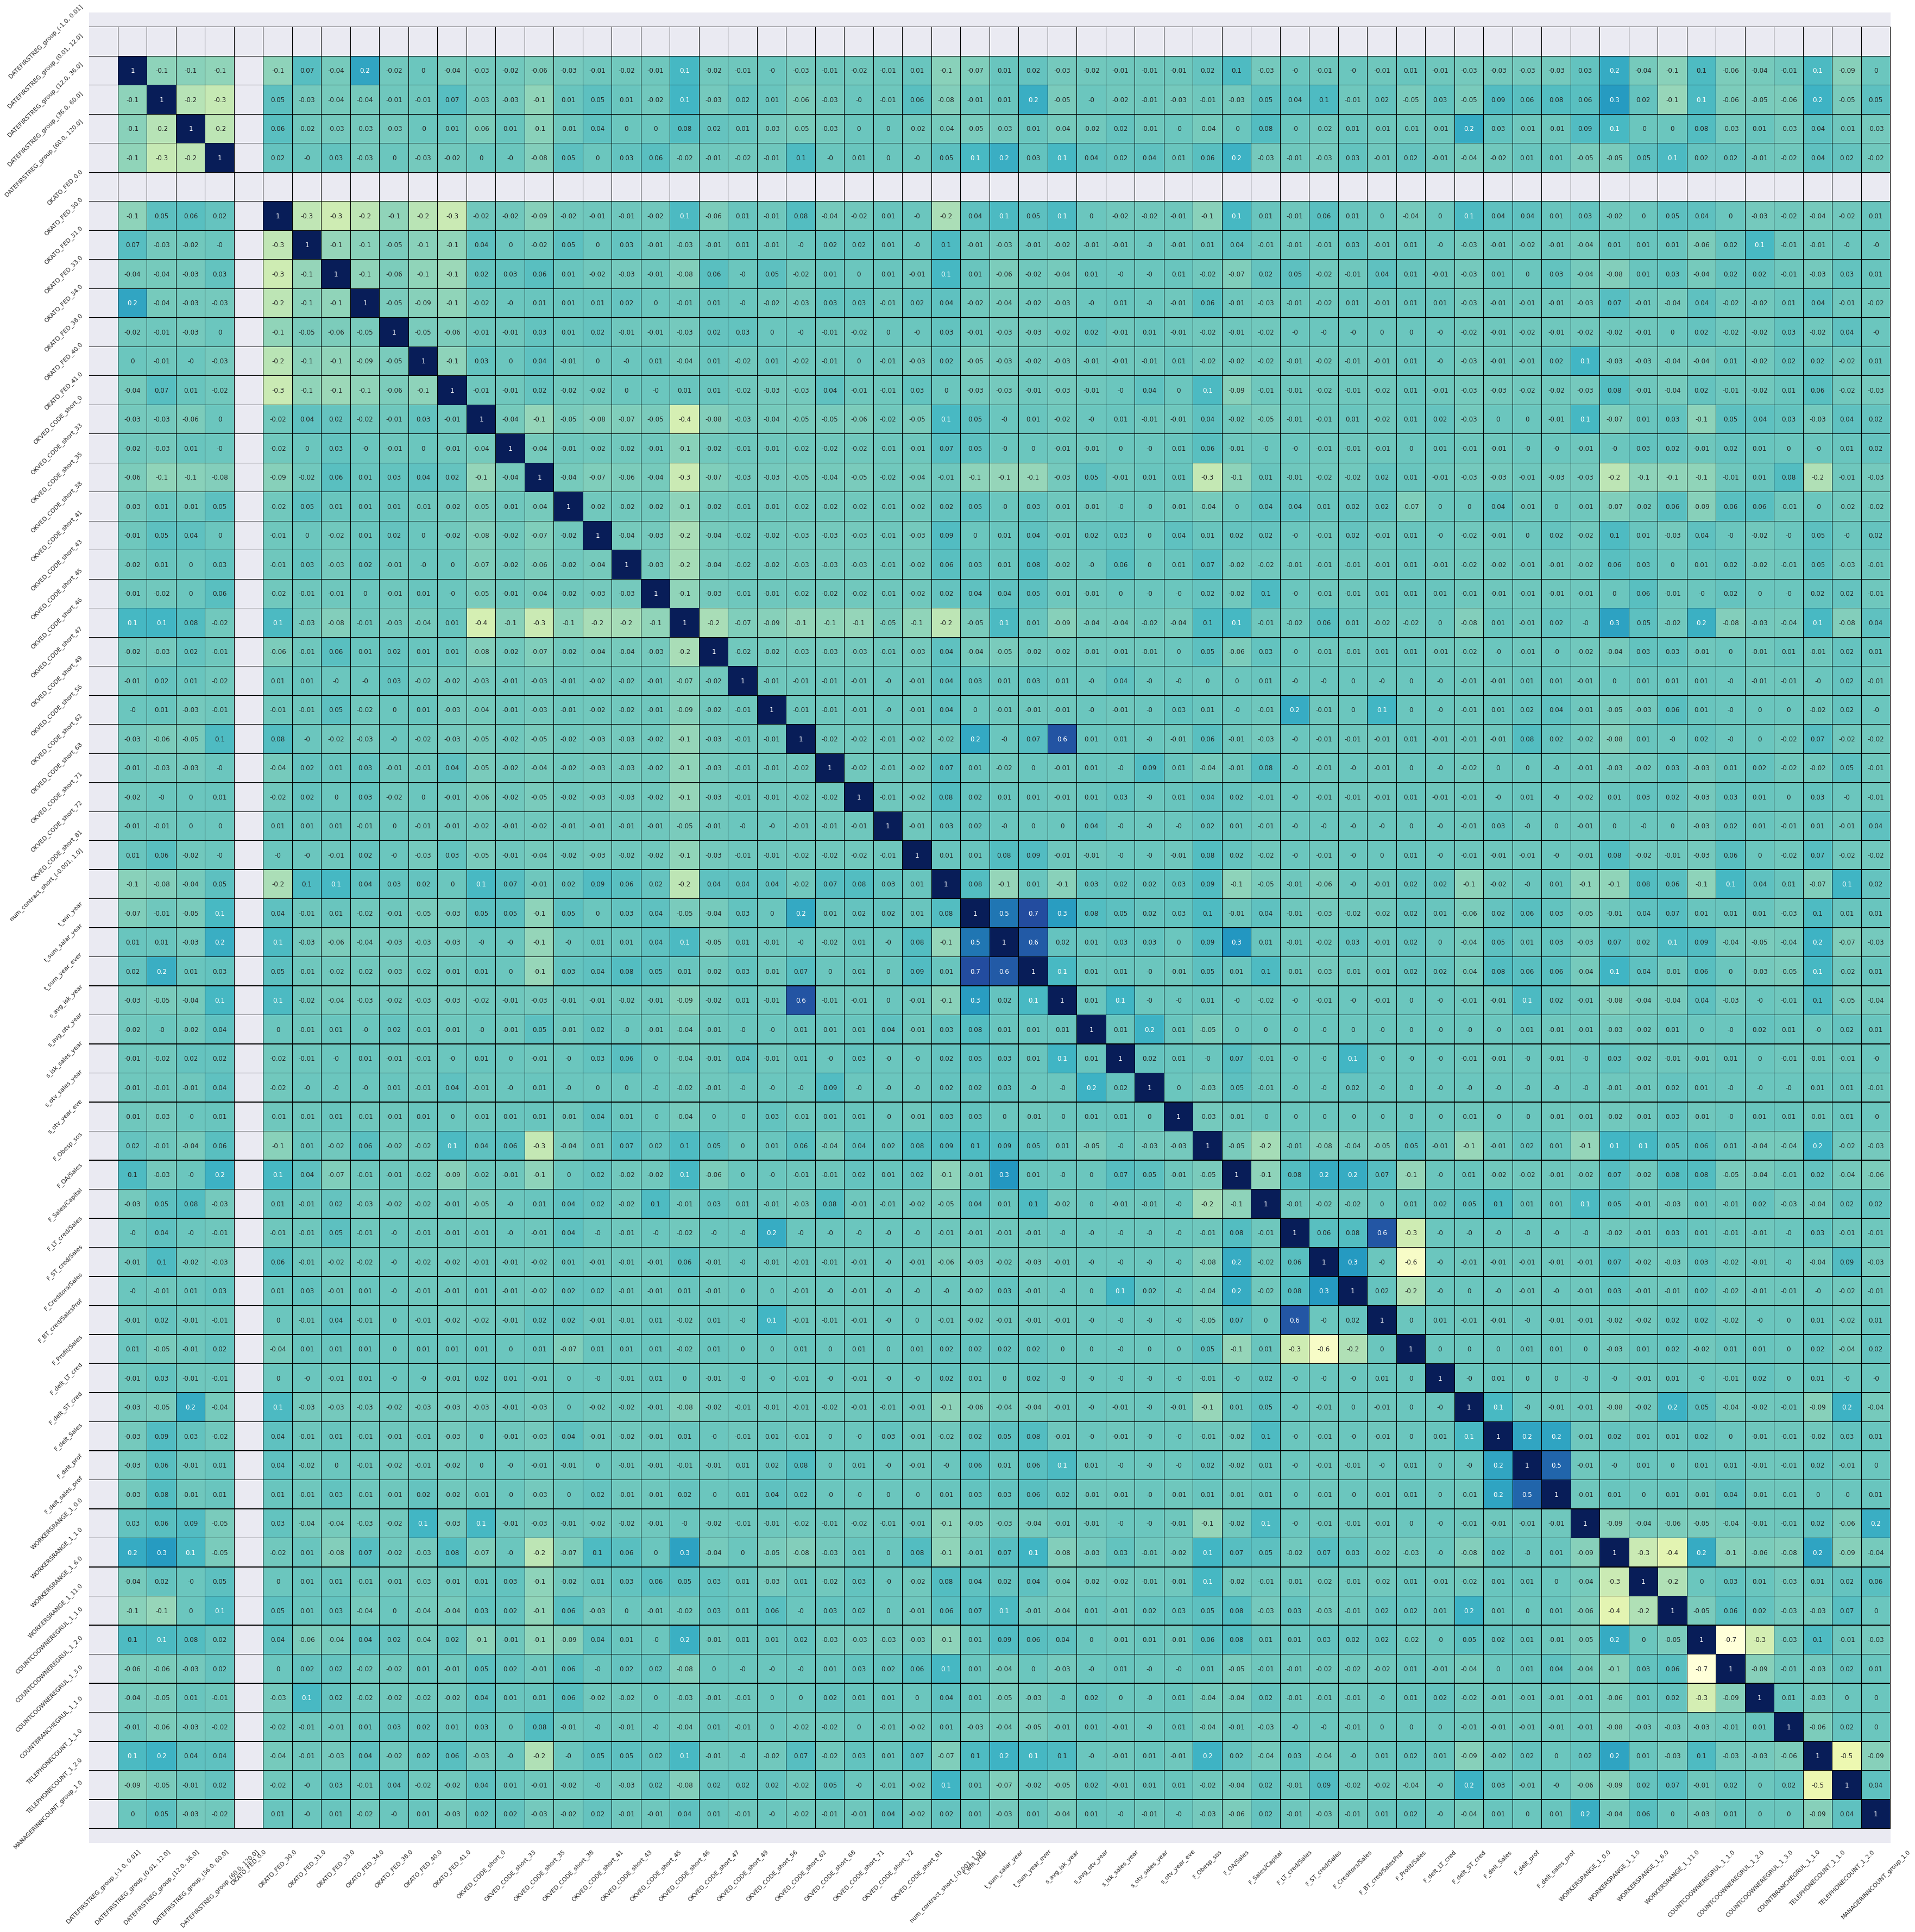

In [26]:
corr_matrix(X_train_OSN, 'train_OSN')

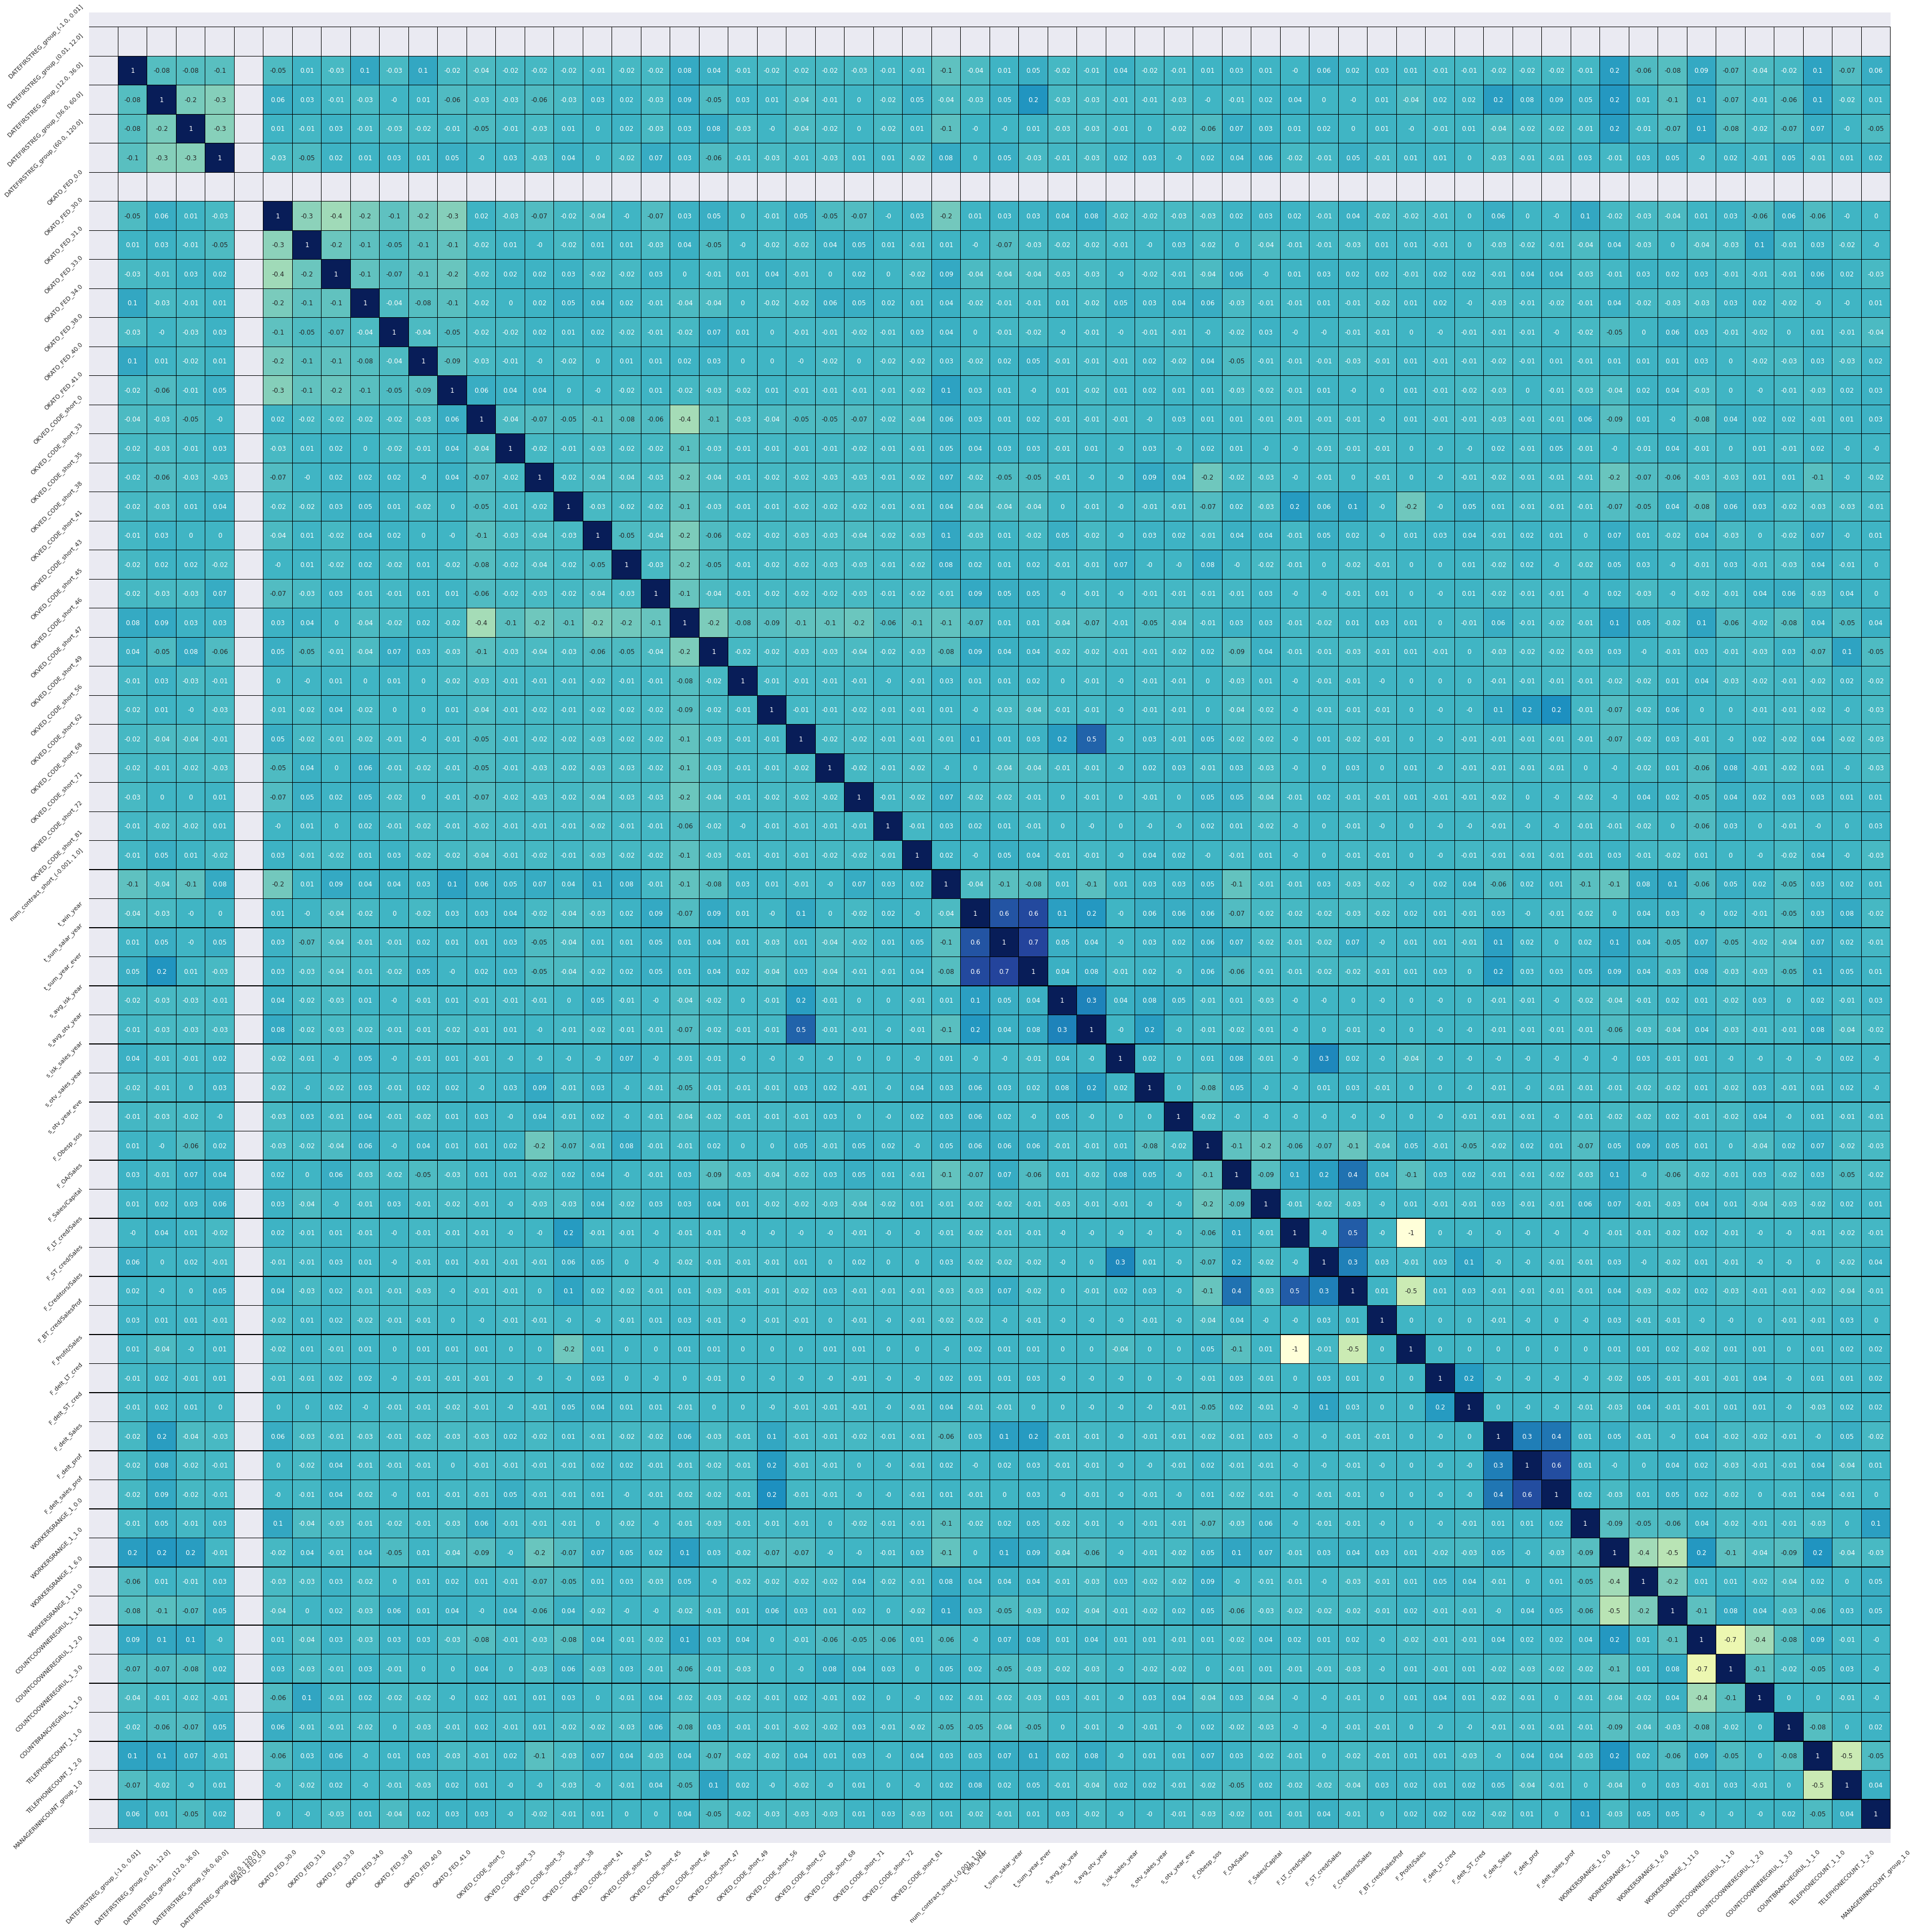

In [27]:
corr_matrix(X_test_OSN, 'test_OSN')

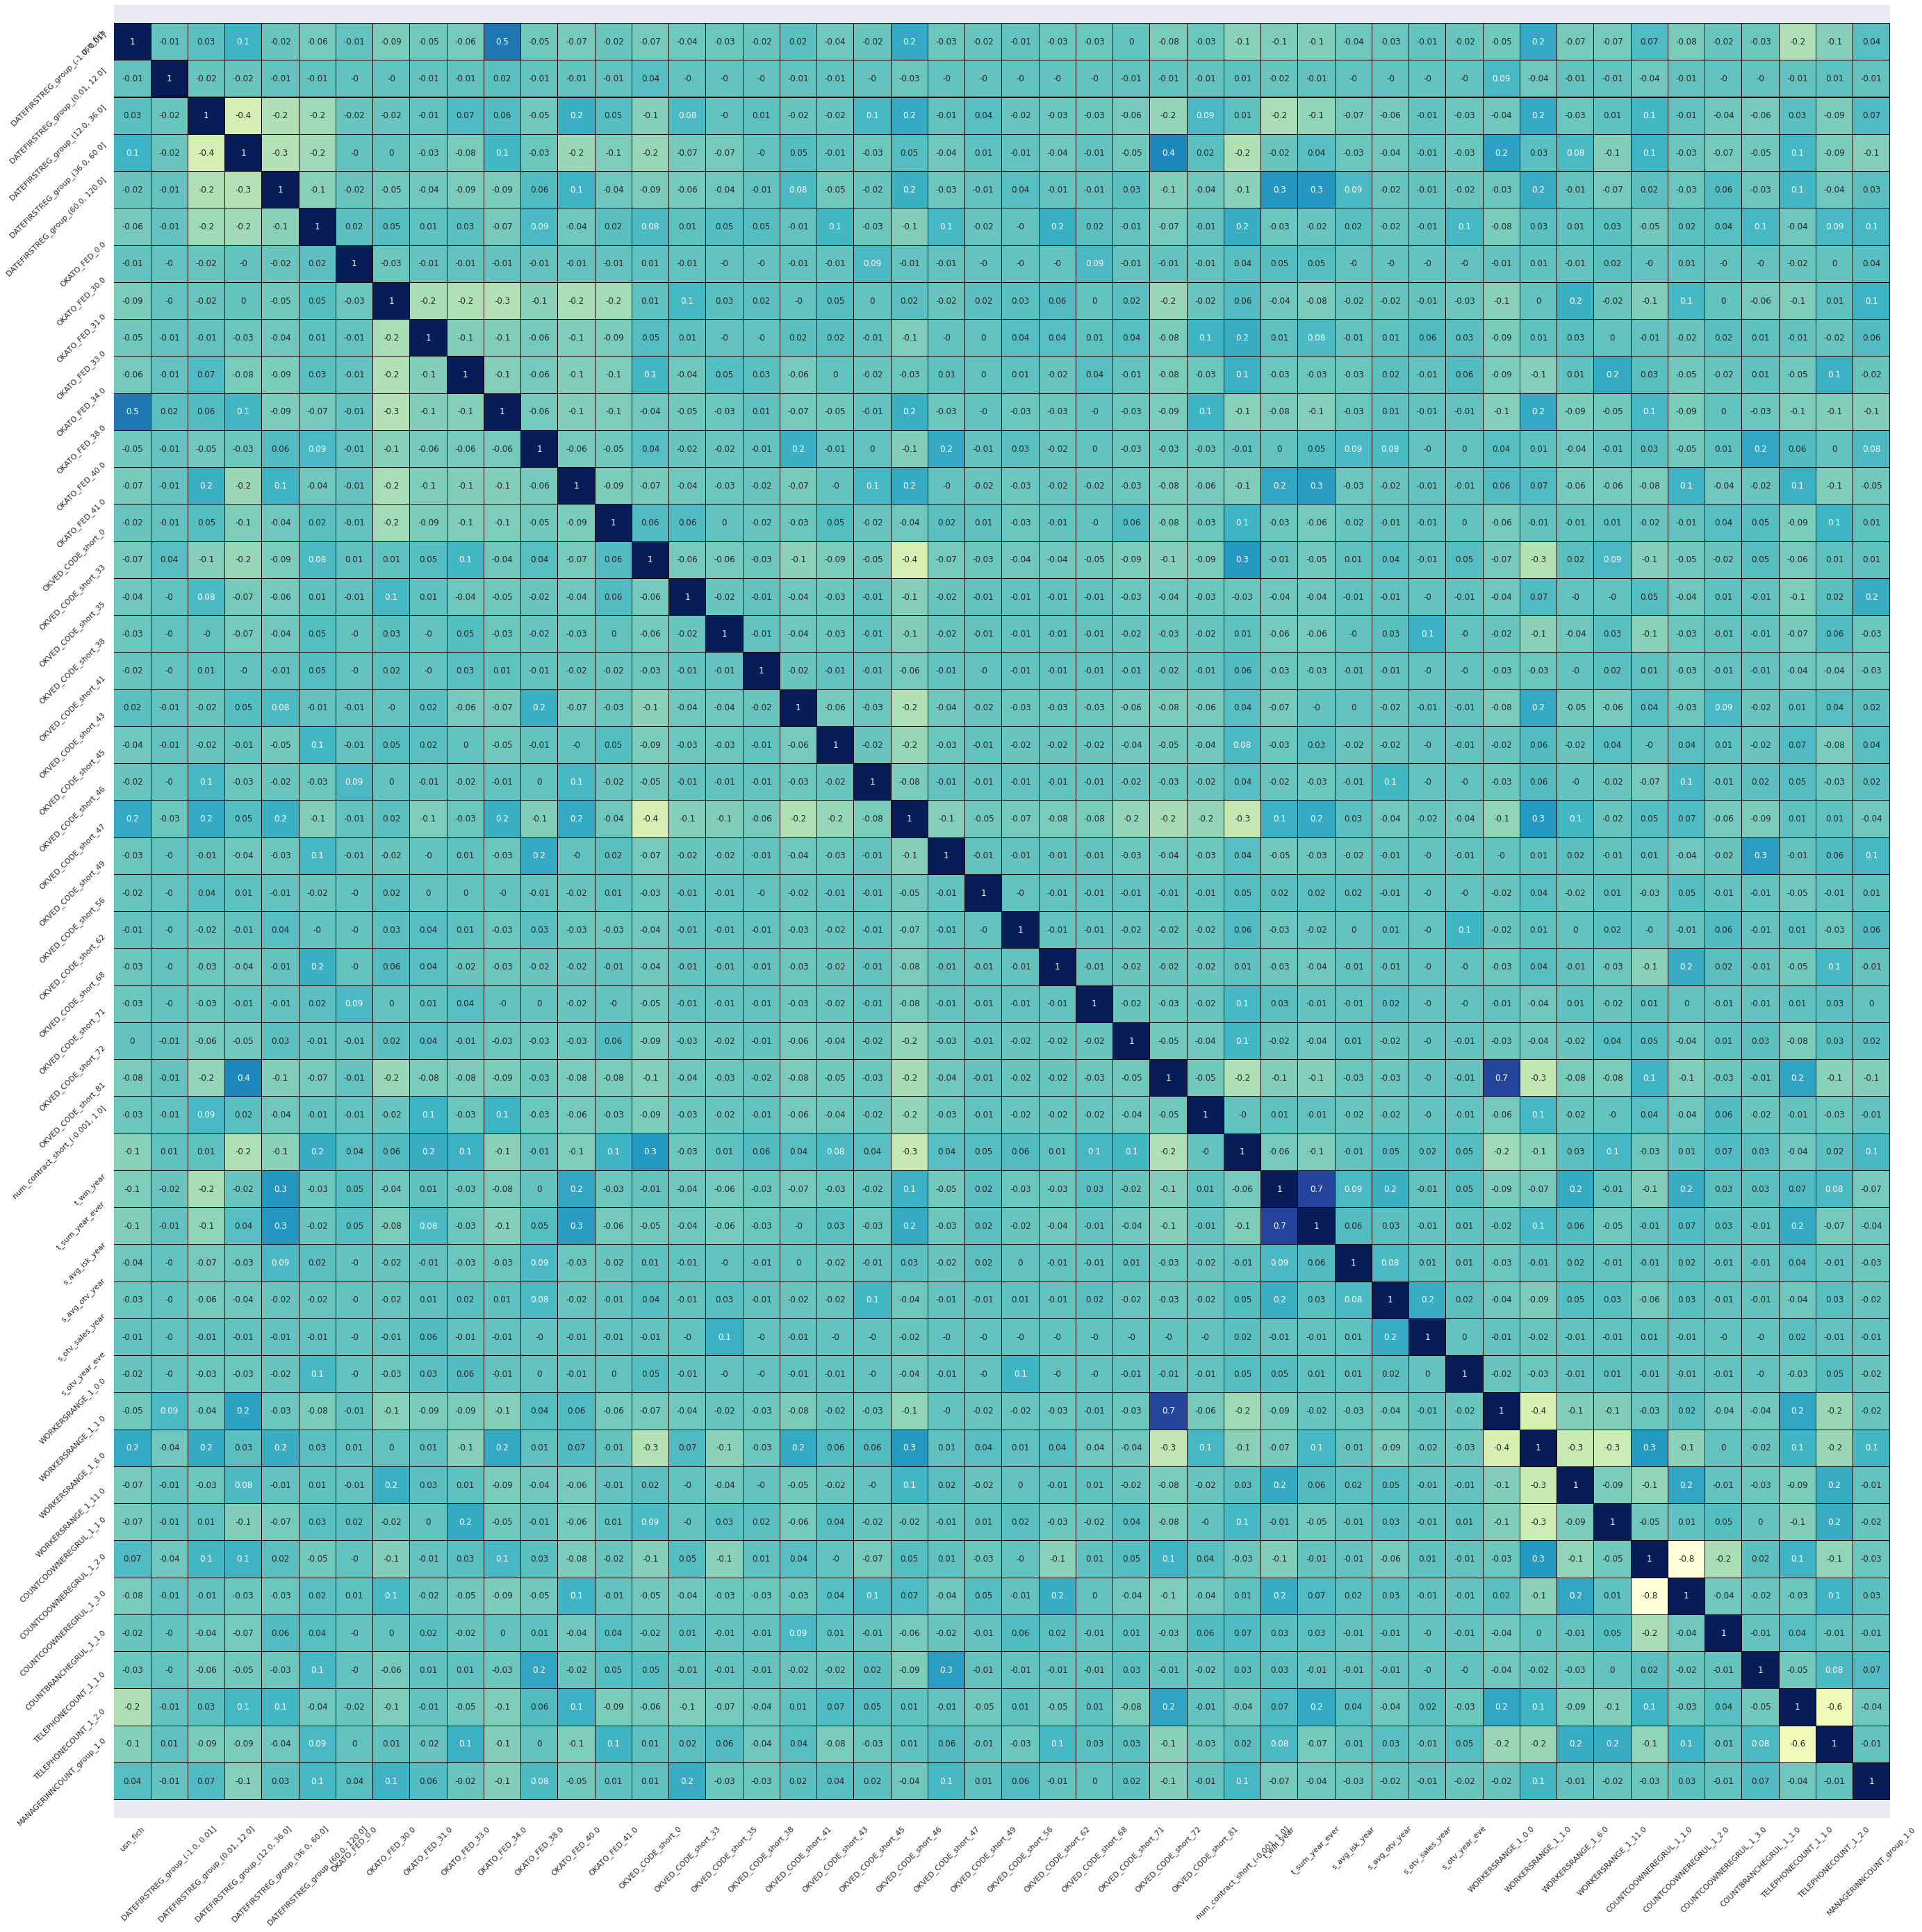

In [28]:
corr_matrix(X_train_USN, 'train_USN')

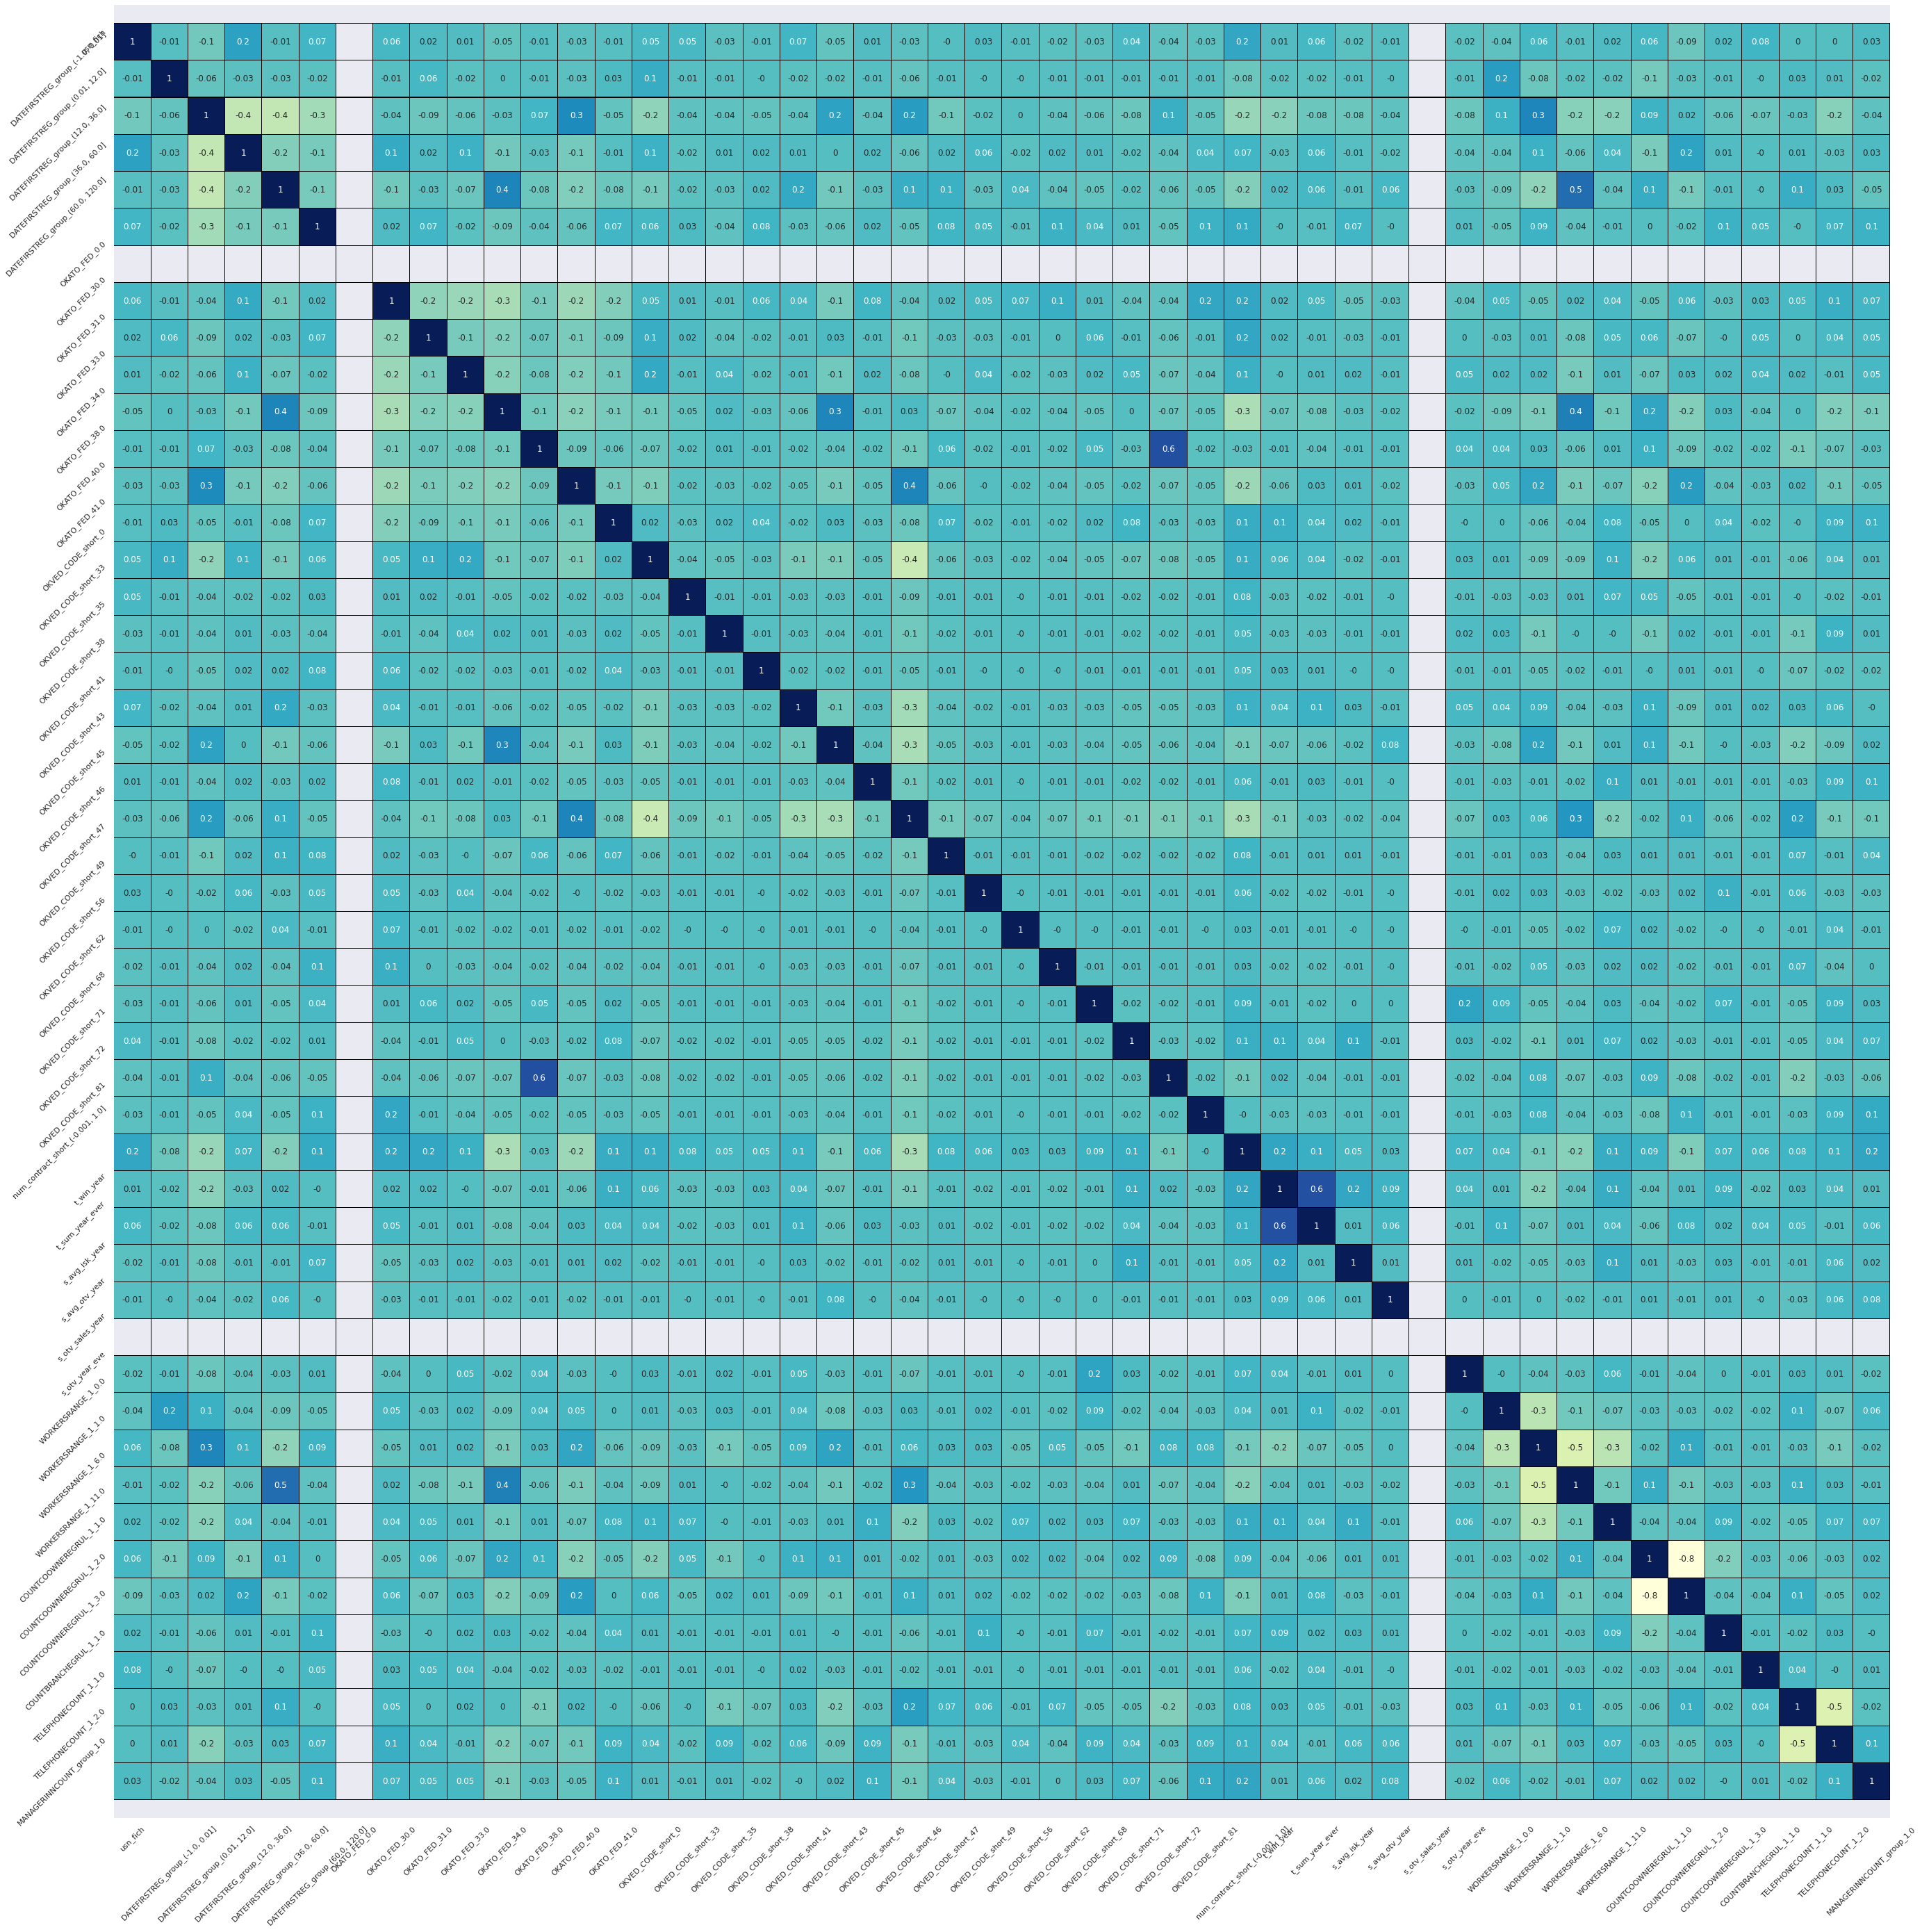

In [29]:
corr_matrix(X_test_USN, 'test_USN')

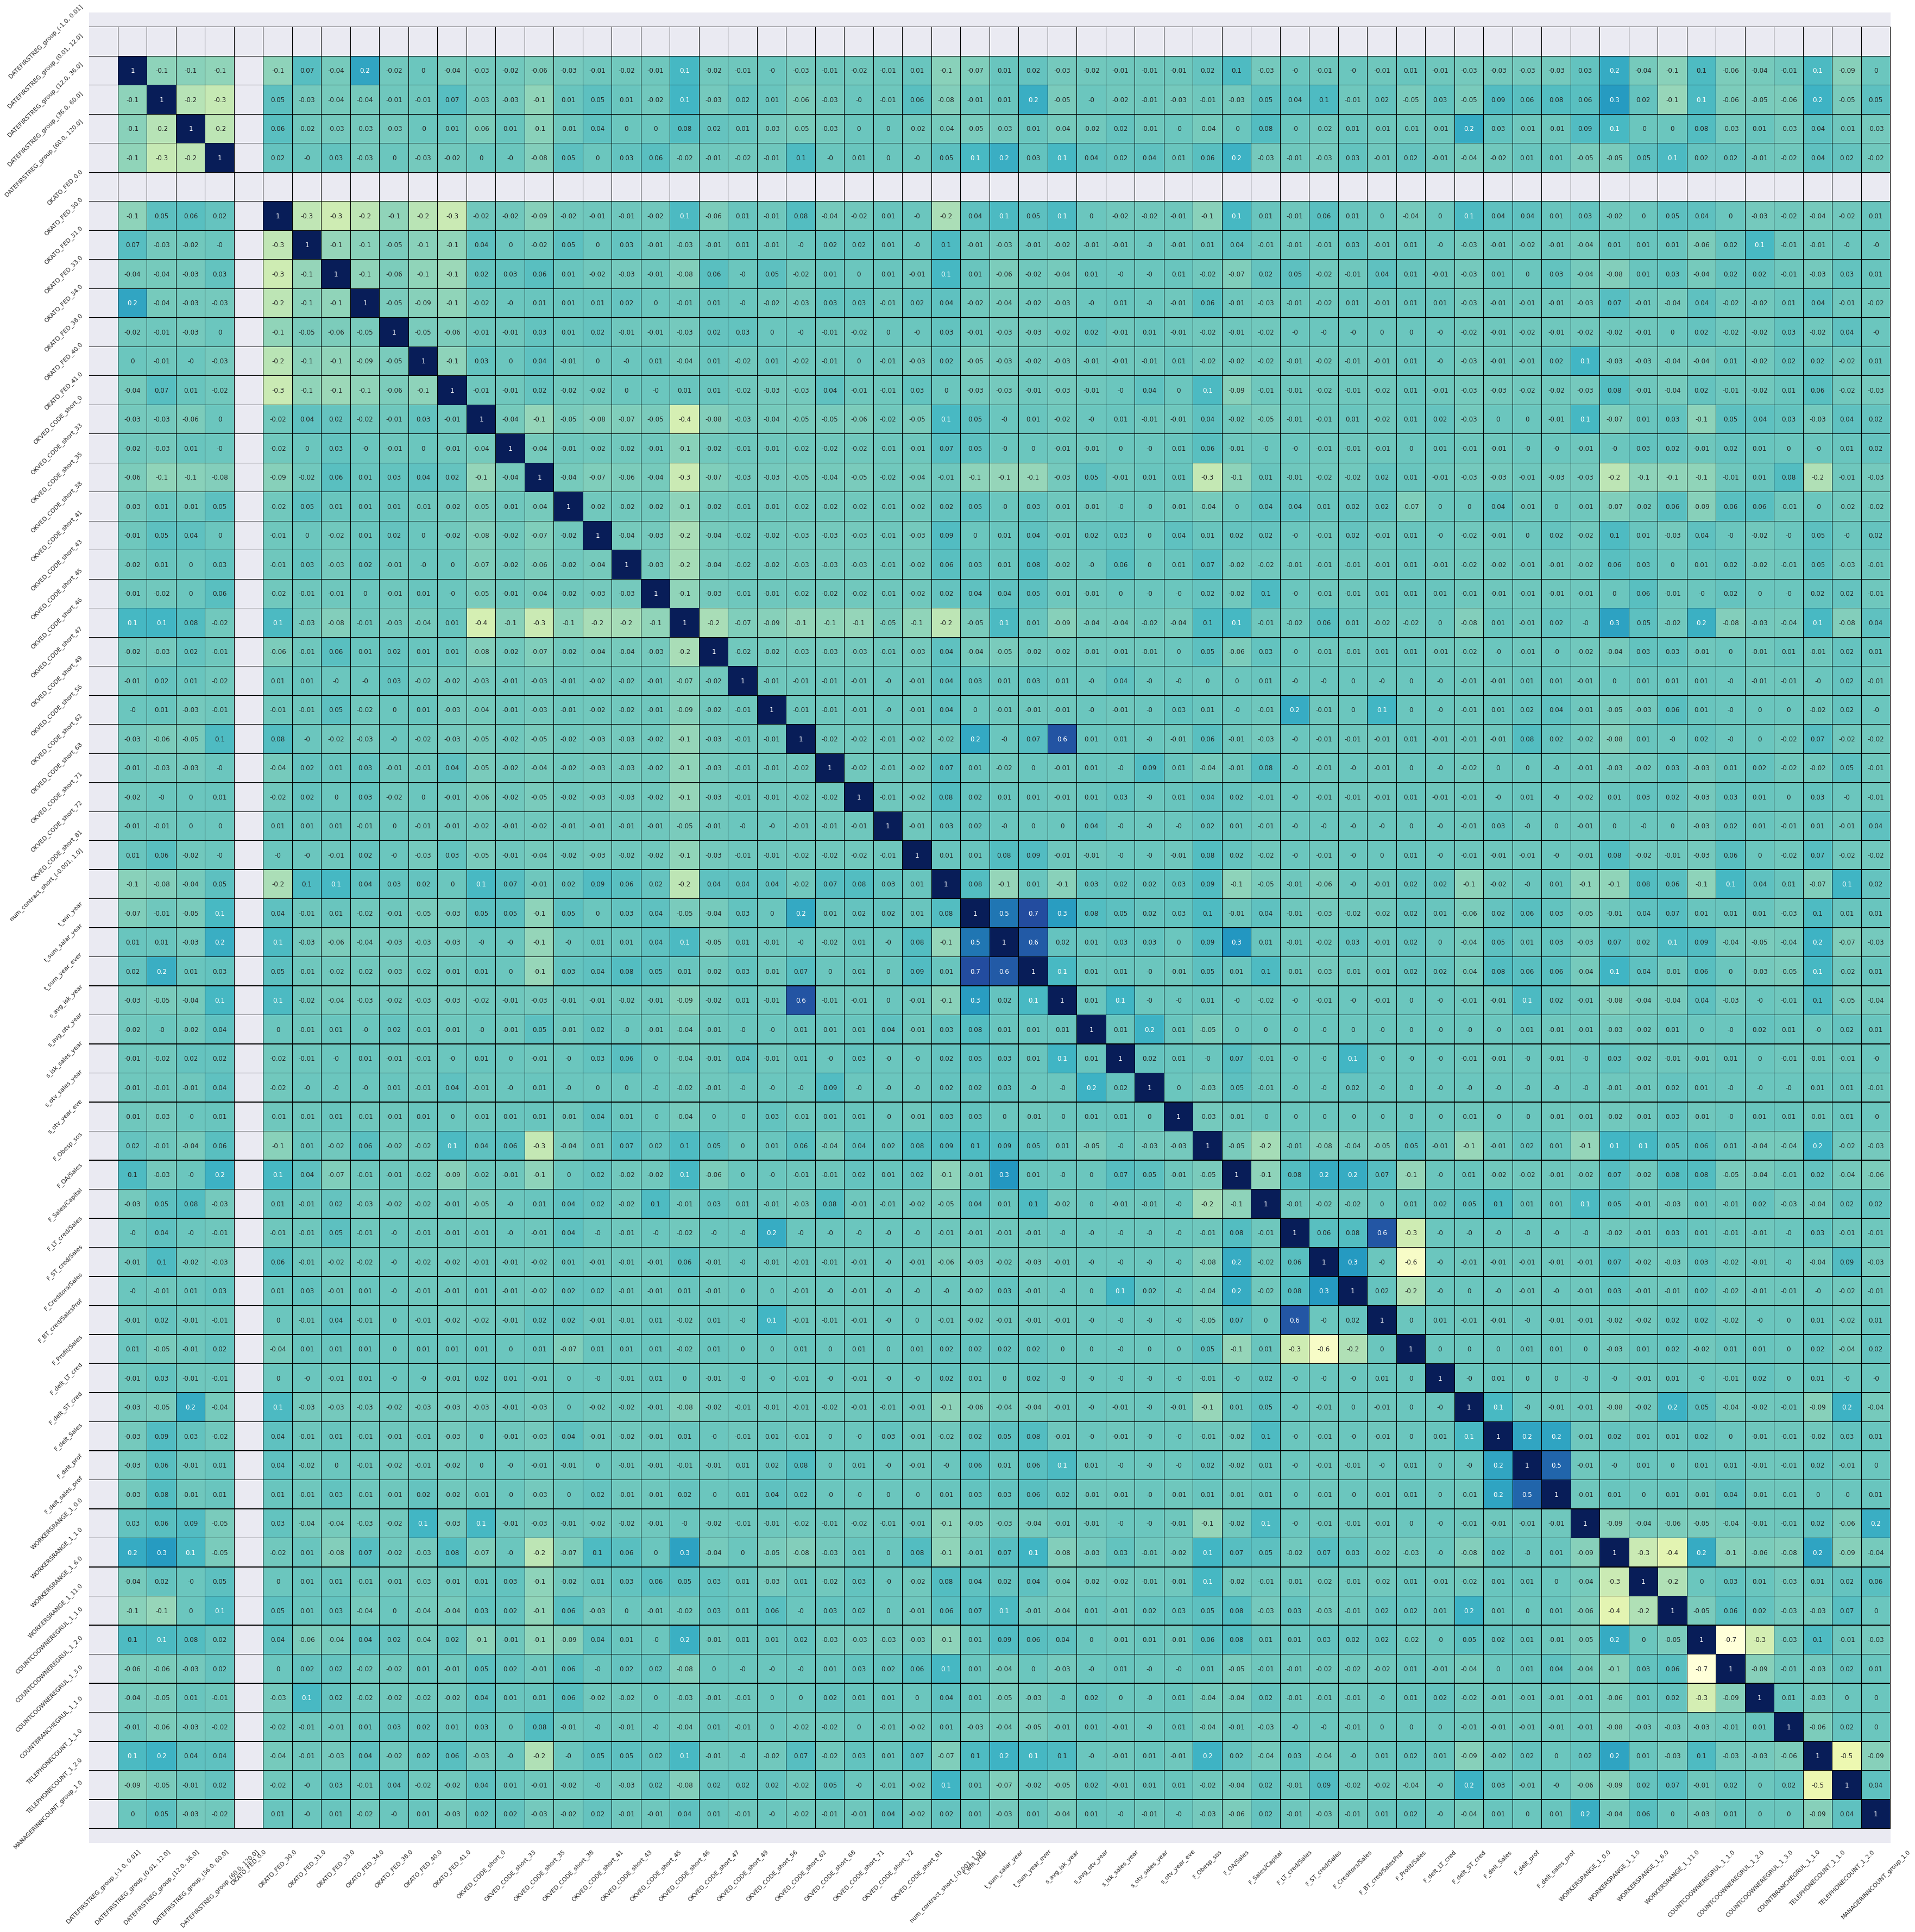

In [30]:
corr_matrix(X_train_OSN, 'train_IP')

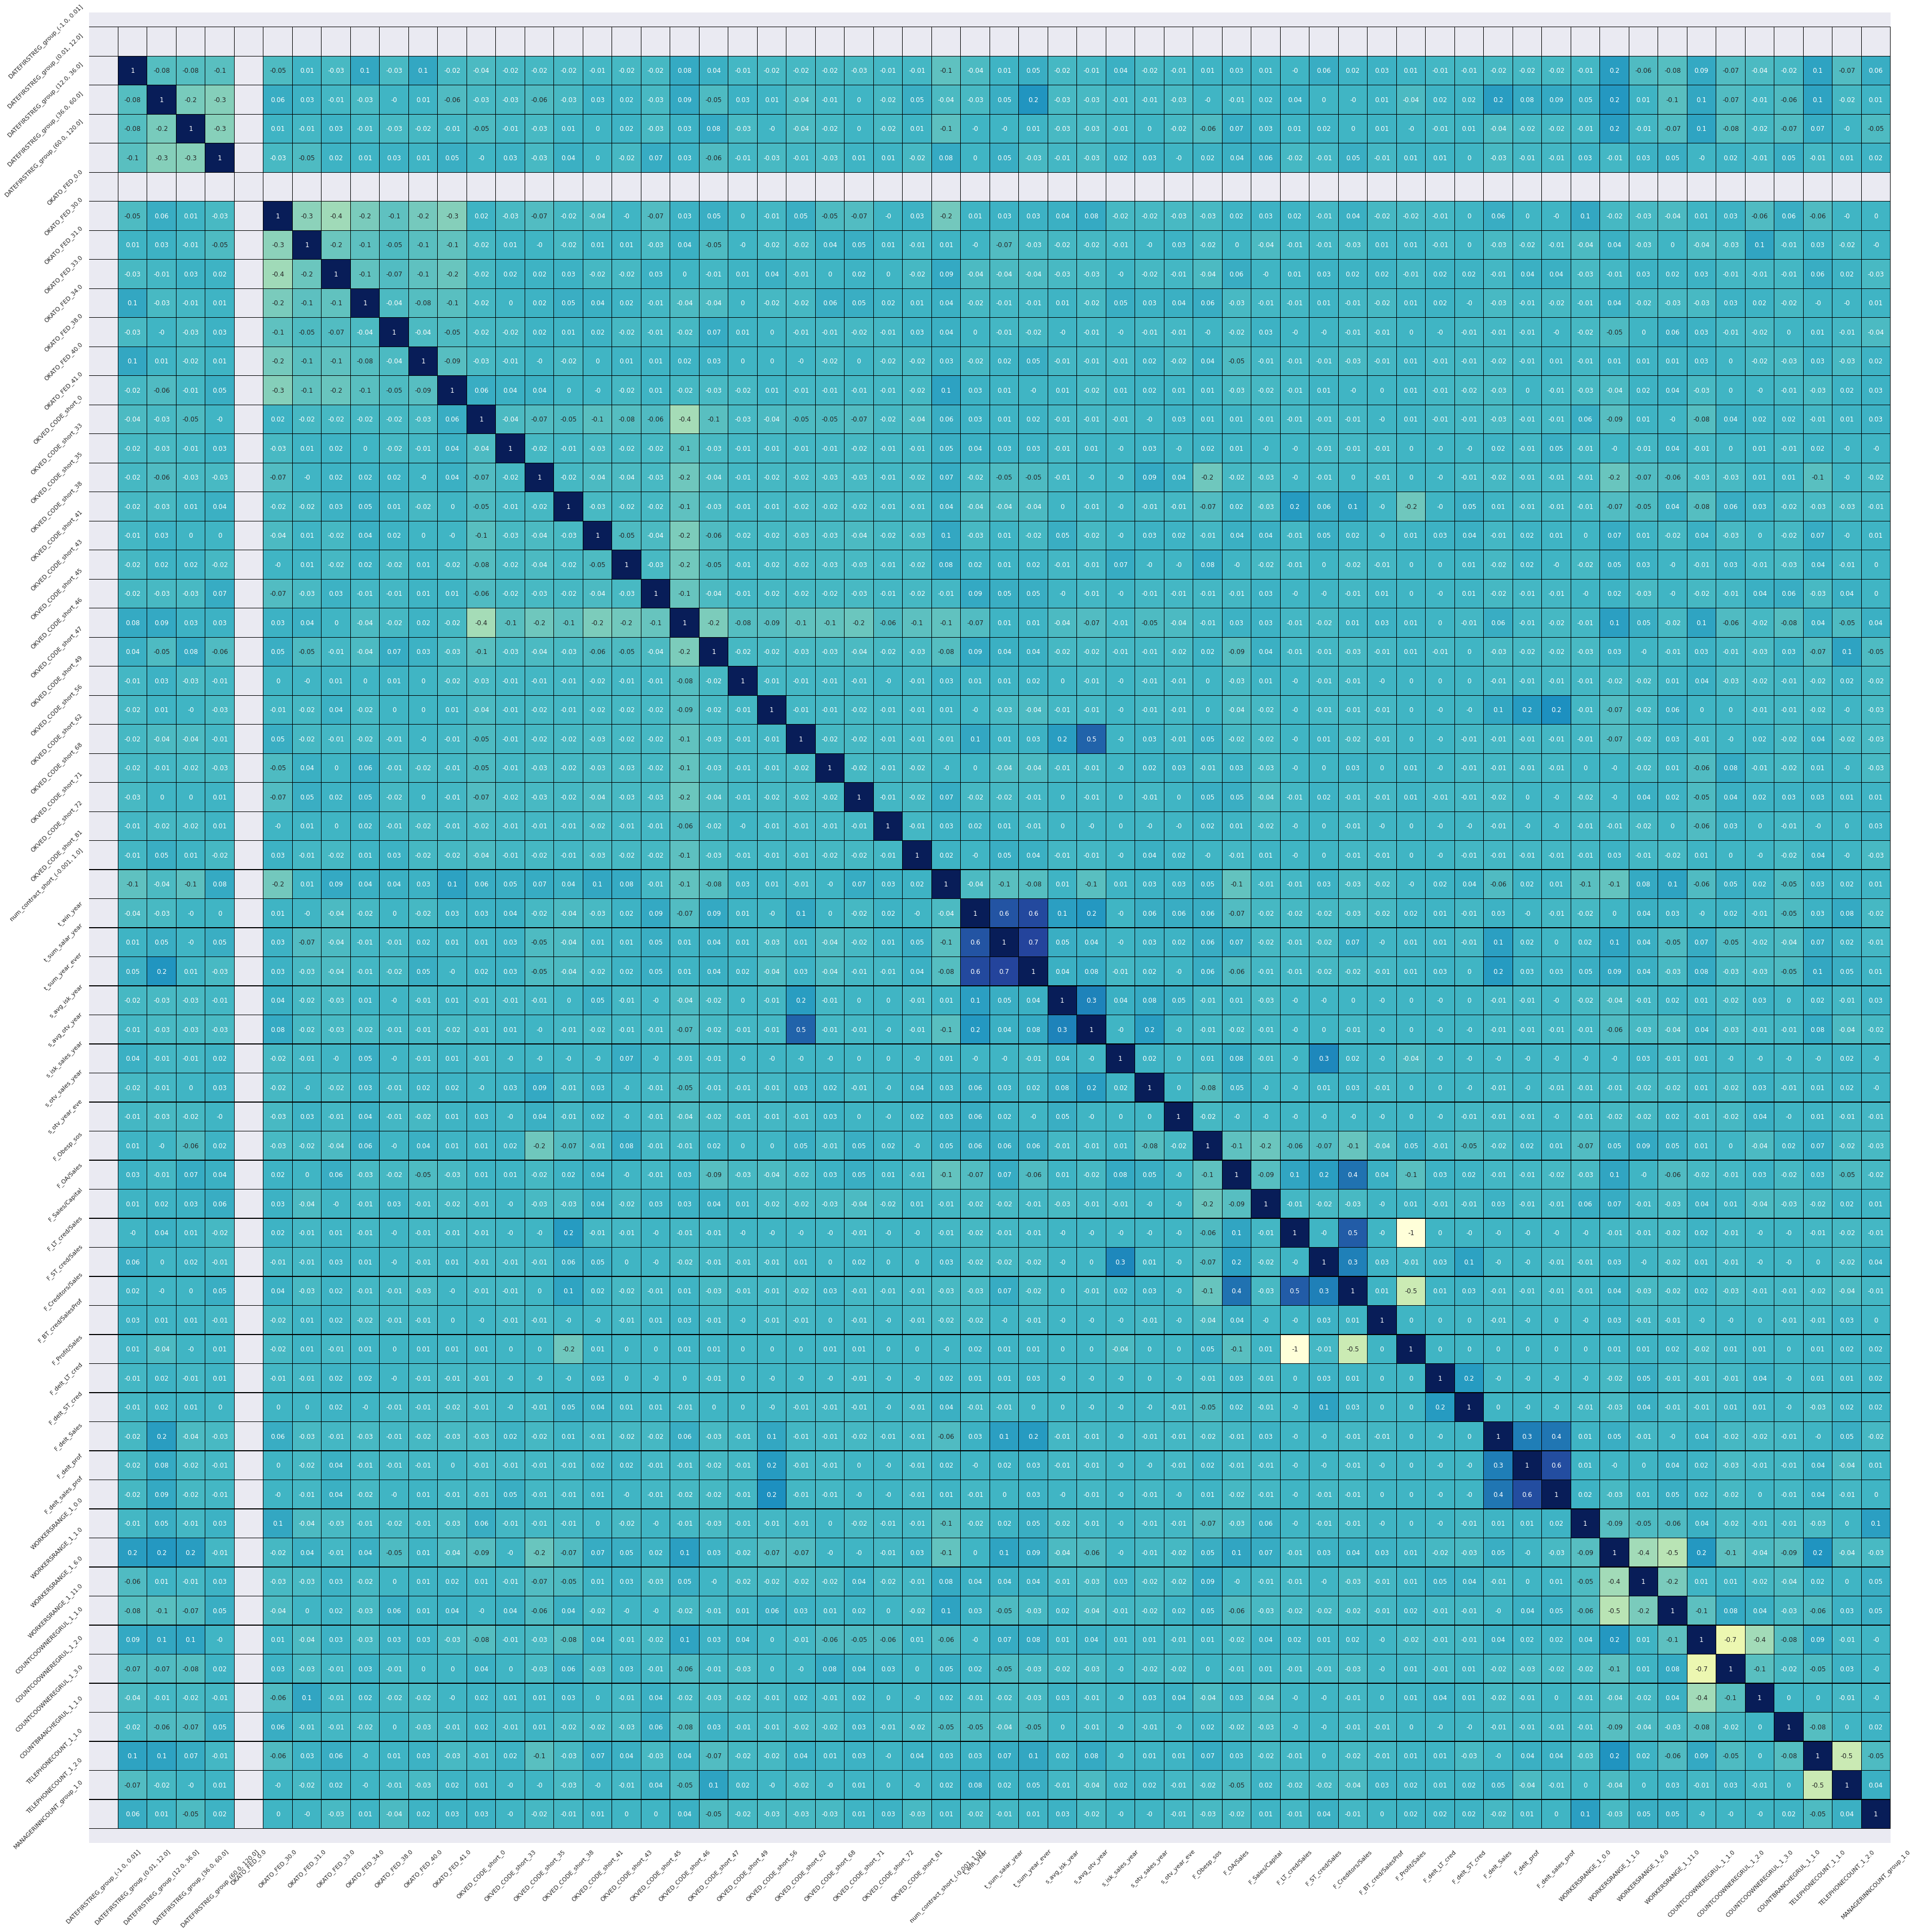

In [31]:
corr_matrix(X_test_OSN, 'test_IP')

In [32]:
local_stop_cols = ['s_otv_sales_year']
local_stop_col2 = ['s_avg_isk_year', 's_avg_otv_year']

X_train_OSN = X_train_OSN.loc[:, [i for i in X_train_OSN.columns 
                                     if i not in local_stop_col2]]
X_test_OSN  = X_test_OSN.loc[:, [i for i in X_test_OSN.columns 
                                     if i not in local_stop_col2]]

X_train_USN = X_train_USN.loc[:, [i for i in X_train_USN.columns 
                                     if i not in local_stop_cols]]
X_test_USN  = X_test_USN.loc[:, [i for i in X_test_USN.columns 
                                     if i not in local_stop_cols]]

X_train_IP = X_train_IP.loc[:, [i for i in X_train_IP.columns 
                                     if i not in local_stop_cols]]
X_test_IP  = X_test_IP.loc[:,  [i for i in X_test_IP.columns 
                                     if i not in local_stop_cols]]

## 4. Обучение модели

### 4.1. Базовая функция обучения

In [33]:
def catboost_model(data, targets, test_data, params = []):

    features = data.columns
    targets  = targets

    cv = StratifiedKFold(n_splits = 5, random_state=100, shuffle=True)

    oof         = np.zeros(len(data))
    train_preds = np.zeros(len(data))
    tree_params = params
    models      = []
    best_score  = 0
    best_model  = None

    for fold_, (train_idx, val_idx) in enumerate(cv.split(data, targets), 1):
        print(f'Training with fold {fold_} started.')
        model           = cb.CatBoostClassifier(**tree_params)    
        X_train, X_val  = data.iloc[train_idx], data.iloc[val_idx]    
        y_train, y_val  = targets[train_idx],   targets[val_idx]
        train_pool = cb.Pool(X_train, y_train)
        val_pool   = cb.Pool(X_val,   y_val)
    
        model.fit(  train_pool, eval_set=[val_pool], 
                    early_stopping_rounds = 100, 
                    verbose_eval          = 50, 
                    use_best_model        = True, 
                    plot                  = False)
    
        oof[val_idx] = model.predict_proba(val_pool)[:, 1]
        score_ = roc_auc_score(y_val, oof[val_idx])
        if score_ > best_score:
            best_model  = model
    
        train_preds[train_idx] += model.predict_proba(train_pool)[:, 1]/(cv.n_splits-1)
        models.append(model)
        print(f'Training with fold {fold_} completed.')

    print('Train roc-auc', roc_auc_score(targets, train_preds))
    print('CV roc-auc',    roc_auc_score(targets, oof))

    score     = np.zeros(len(test_data))
    test_pool = cb.Pool(test_data#[features]
                        )

    for model in models:
        score += model.predict_proba(test_data)[:, 1] / len(models)

    score_base = pd.DataFrame({ 'ind' : test_data.index,
                                'TARGET' : score }).set_index(['ind'])
                                
    score_base = score_base.join(test.iloc[:,0], how = 'left').iloc[:,[1,0]]

    best_model_score_base = pd.DataFrame({ 'ind' : test_data.index,
                                'TARGET' : model.predict_proba(test_data)[:, 1] 
                                }).set_index(['ind'])
    best_model_score_base = best_model_score_base.join(test.iloc[:,0], 
                                                       how = 'left').iloc[:,[1,0]]

    return score_base, best_model_score_base

### 4.2. Решение / интерпретируемое / для внд по 590-п

In [34]:
USN_score, USN_best_score = catboost_model(X_train_USN, y_train_USN, 
                           X_test_USN,   params =  {'learning_rate':    0.0074,
                                                    'iterations':       3000,
                                                    'max_depth':        4, 
                                                    'eval_metric':      'AUC',
                                                    'loss_function':    'Logloss',
                                                    'random_state':     100,
                                                    'l2_leaf_reg':      1, 
                                                    'task_type':        'GPU'})

Training with fold 1 started.
0:	learn: 0.9015401	test: 0.8952780	best: 0.8952780 (0)	total: 18.6ms	remaining: 55.8s
50:	learn: 0.9267756	test: 0.9130563	best: 0.9132707 (48)	total: 889ms	remaining: 51.4s
100:	learn: 0.9293195	test: 0.9190581	best: 0.9190581 (100)	total: 1.77s	remaining: 50.8s
150:	learn: 0.9337867	test: 0.9232064	best: 0.9234586 (147)	total: 2.65s	remaining: 49.9s
200:	learn: 0.9356165	test: 0.9240764	best: 0.9241017 (199)	total: 3.51s	remaining: 48.9s
250:	learn: 0.9376904	test: 0.9265603	best: 0.9267620 (244)	total: 4.37s	remaining: 47.8s
300:	learn: 0.9392873	test: 0.9272538	best: 0.9272538 (300)	total: 5.24s	remaining: 47s
350:	learn: 0.9413864	test: 0.9288803	best: 0.9288803 (350)	total: 6.11s	remaining: 46.1s
400:	learn: 0.9428322	test: 0.9301538	best: 0.9301538 (400)	total: 6.98s	remaining: 45.2s
450:	learn: 0.9441641	test: 0.9307843	best: 0.9308095 (447)	total: 7.84s	remaining: 44.3s
500:	learn: 0.9457192	test: 0.9316543	best: 0.9316543 (500)	total: 8.7s	remai

In [35]:
OSN_score, OSN_best_score  = catboost_model(X_train_OSN, y_train_OSN, 
                           X_test_OSN,  params =   {'learning_rate':    0.008,
                                                    'iterations':       3000,
                                                    'max_depth':        5, 
                                                    'eval_metric':      'AUC',
                                                    'loss_function':    'Logloss',
                                                    'random_state':     100,
                                                    'l2_leaf_reg':      1, 
                                                    'task_type':        'GPU'})

Training with fold 1 started.
0:	learn: 0.8731827	test: 0.8798814	best: 0.8798814 (0)	total: 25.9ms	remaining: 1m 17s
50:	learn: 0.9035406	test: 0.9100044	best: 0.9100534 (49)	total: 1.27s	remaining: 1m 13s
100:	learn: 0.9089804	test: 0.9145093	best: 0.9145354 (99)	total: 2.53s	remaining: 1m 12s
150:	learn: 0.9132894	test: 0.9183060	best: 0.9183060 (150)	total: 3.75s	remaining: 1m 10s
200:	learn: 0.9173485	test: 0.9208214	best: 0.9208214 (200)	total: 4.97s	remaining: 1m 9s
250:	learn: 0.9210950	test: 0.9226351	best: 0.9226678 (249)	total: 6.2s	remaining: 1m 7s
300:	learn: 0.9245001	test: 0.9248414	best: 0.9248414 (300)	total: 7.43s	remaining: 1m 6s
350:	learn: 0.9272642	test: 0.9263035	best: 0.9263035 (350)	total: 8.65s	remaining: 1m 5s
400:	learn: 0.9298313	test: 0.9279144	best: 0.9279144 (400)	total: 9.87s	remaining: 1m 3s
450:	learn: 0.9319855	test: 0.9288041	best: 0.9288041 (450)	total: 11.1s	remaining: 1m 2s
500:	learn: 0.9339612	test: 0.9301370	best: 0.9301370 (500)	total: 12.3s	

In [36]:
IP_score, IP_best_score  = catboost_model( X_train_IP, y_train_IP, 
                           X_test_IP,  params =    {'learning_rate':    0.01,
                                                    'iterations':       3000,
                                                    'max_depth':        2, 
                                                    'eval_metric':      'AUC',
                                                    'loss_function':    'Logloss',
                                                    'random_state':     100,
                                                    'l2_leaf_reg':      1, 
                                                    'task_type':        'GPU'})

Training with fold 1 started.
0:	learn: 0.8652462	test: 0.8429797	best: 0.8429797 (0)	total: 16.3ms	remaining: 48.9s
50:	learn: 0.8957081	test: 0.8824525	best: 0.8833818 (48)	total: 808ms	remaining: 46.7s
100:	learn: 0.9184522	test: 0.9087796	best: 0.9087796 (100)	total: 1.58s	remaining: 45.5s
150:	learn: 0.9223548	test: 0.9135795	best: 0.9138051 (149)	total: 2.35s	remaining: 44.4s
200:	learn: 0.9264067	test: 0.9176576	best: 0.9176576 (200)	total: 3.14s	remaining: 43.7s
250:	learn: 0.9281883	test: 0.9199042	best: 0.9199132 (249)	total: 3.91s	remaining: 42.8s
300:	learn: 0.9293291	test: 0.9213884	best: 0.9214741 (287)	total: 4.68s	remaining: 42s
350:	learn: 0.9304186	test: 0.9231477	best: 0.9233282 (344)	total: 5.46s	remaining: 41.2s
400:	learn: 0.9311427	test: 0.9240951	best: 0.9242394 (397)	total: 6.23s	remaining: 40.4s
450:	learn: 0.9323128	test: 0.9258454	best: 0.9258454 (450)	total: 6.99s	remaining: 39.5s
500:	learn: 0.9327762	test: 0.9263507	best: 0.9264499 (498)	total: 7.76s	rema

In [37]:
from google.colab import drive

In [38]:
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
PATH = '/content/drive/My Drive/mkb/'

In [40]:
submit = pd.concat([OSN_score, USN_score, IP_score]
                   ).sort_values(by=['id_contract'])
submit.to_csv(PATH + 'submit_file_score_8.csv', sep=';', index=False)

In [41]:
submit

id_contract    TARGET
ind                        
0           17892  0.062302
1           17893  0.054499
2           17894  0.180299
3           17895  0.349013
4           17896  0.389696
...           ...       ...
7325        25217  0.422650
7326        25218  0.021365
7327        25219  0.507563
7328        25220  0.144278
7329        25221  0.147162

[7330 rows x 2 columns]